In [1]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize']

[6.0, 4.0]

In [4]:
from collections import defaultdict
import logging
import pandas as pd

EOS = 'EOS'
OMG = 'OMG'
USDT = 'USDT'
QTUM = 'QTUM'
ELF = 'ELF'
NTL = 'NTL'


class BotLogger:
    @classmethod
    def debug(cls, *args):
        return logging.debug(*args)

    @classmethod
    def error(cls, *args):
        return logging.error(*args)

    @classmethod
    def info(cls, *args):
        return logging.info(*args)


bot_logger = BotLogger()


def read_csv(name, type='5m'):
    return pd.read_csv(
    './csv/binance_%s_%s_kline.csv' %(name, type),
    names=[name, 'open', 'high', 'low', 'last', 'type', 'timestamp']
)


def get_usdt_price_pandas(target_symbol):
    target2eth = read_csv('%s_ETH' % target_symbol)
    eth2usdt = read_csv('ETH_USDT')
    target2eth2usdt = pd.merge(target2eth, eth2usdt, on='timestamp')
    target2eth2usdt['price_usdt'] = target2eth2usdt['last_x'] * target2eth2usdt['last_y']
    return target2eth2usdt


def get_price_with_impact_cost(min_price, premium_rate):
    return min_price * (1 + premium_rate or 0)


def get_auction_premium_rate():
    # return random.randint(1, 20) / 100.0
    return 0.02


def get_redeem_premium_rate():
    return 0.02


def get_ntl_flat_price_for_component(component_last_bid, component_flat_price):
    return component_last_bid * component_flat_price


def is_auction_ok(current_price_of_ntl, average_price_of_ntl_per_k):
    current_price_of_ntl = get_price_with_impact_cost(
        current_price_of_ntl,
        get_auction_premium_rate()
    )
    # print("auction avg and current: ", average_price_of_ntl_per_k, current_price_of_ntl)
    return (
        average_price_of_ntl_per_k > current_price_of_ntl,
        (average_price_of_ntl_per_k - current_price_of_ntl) / float(
            current_price_of_ntl
        )
    )

def is_redeem_ok(current_price_of_ntl, average_price_of_ntl_per_k):
    current_price_of_ntl = get_price_with_impact_cost(
        current_price_of_ntl,
        get_redeem_premium_rate()
    )
    # print("redeem detection avg and current: ", average_price_of_ntl_per_k, current_price_of_ntl)
    return (
        average_price_of_ntl_per_k < current_price_of_ntl,
        (
            (current_price_of_ntl - average_price_of_ntl_per_k) / float(
                average_price_of_ntl_per_k
            )
        )
    )


NUM_tokens = dict(
    (
        (OMG, 0),
        (EOS, 0),
        # (ELF, 10 * 1000),
        # (USDT, 10 * 1000),
        # (QTUM, 10 * 1000),
    )
)

NLT_reserve = dict(
    (
        (OMG, 0),
        (EOS, 0),
        # (ELF, 100 * 100 * 10 * 2),
        # (USDT, 100 * 100 * 10 * 2),
        # (QTUM, 100 * 100 * 10 * 60),
    )
)

NLT_accounts = {
    'the-god': sum((value for value in NLT_reserve.values()))
}
NLT_components = {}
NLT_AUCTION_WINDOW = 360


class Component:
    min_bid = float(1)
    timestamp = 0
    auction_window = NLT_AUCTION_WINDOW

    def __init__(self, token):
        self.minted = {}
        self.token = token
        self.reserves = NLT_reserve
        self.token_reserves = NUM_tokens
        self.components = NLT_components
        self.components[token] = self
        self.accounts = NLT_accounts

    def __call__(self, timestamp: float):
        self.timestamp = timestamp
        return self

    def __repr__(self):
        return '%s %s => %s NTL' % (
            self.token_reserve, self.token, self.total_supply
        )

    @property
    def total_supply(self) -> float:
        return sum(list(self.reserves.values()))

    @property
    def ntl_reserve(self):
        return self.reserves[self.token]

    @ntl_reserve.setter
    def ntl_reserve(self, v):
        self.reserves[self.token] = v

    @property
    def token_reserve(self):
        return self.token_reserves[self.token]

    def auction(self, bid: float):
        bid = float(bid)
        assert bid > self.min_bid
        if bid > self.min_bid:
            self.min_bid = bid
        self.token_reserve = self.token_reserve + bid
        self.ntl_reserve = self.ntl_reserve + 1000
        print(
            'do auction for 1000 ntl by %s %s' % (
                bid,
                self.token,
            )
        )
        return True

    @token_reserve.setter
    def token_reserve(self, v):
        self.token_reserves[self.token] = v

    def get_num_redeemed(self, num_ntl):
        redeemed = self.token_reserve / float(self.ntl_reserve) * num_ntl
        if redeemed > self.ntl_reserve:
            redeemed = self.ntl_reserve
        return redeemed

    def get_redeem_price_per_k(self):
        return self.token_reserve * 1000 / self.ntl_reserve

    def redeem(self, num_ntl):
        assert num_ntl >= 0
        redeemed = self.get_num_redeemed(num_ntl)
        print(
            'redeeming %s for %s ntl, reserve is %s, redeemed %s' % (
                self.token,
                num_ntl,
                self.token_reserve,
                redeemed,
            )
        )
        self.token_reserve = self.token_reserve - redeemed
        if self.token_reserve < 0:
            import pdb;pdb.set_trace()
        self.ntl_reserve = self.ntl_reserve - num_ntl
        self.min_bid = self.get_redeem_price_per_k()
        return redeemed


class Exchange:
    num_ntl_each_round = 1000

    def __init__(self, symbols):
        """
        :type components: dict[str, sim.netrual.Component]
        """
        self.current_index = 0
        self.symbols = symbols
        self.prices = {}
        self.components = {}
        self.current_prices = defaultdict(int)
        _other_symbol = None
        for symbol in symbols:
            self.components[symbol] = Component(symbol)
            if symbol != USDT:
                _other_symbol = symbol
            else:
                continue
            self.prices[symbol] = get_usdt_price_pandas(symbol)

        self.prices[USDT] = pd.Series(
            dict(
                timestamp=self.prices[_other_symbol].timestamp,
                price_usdt=[1, ] * len(self.prices[_other_symbol]),
            )
        )

    def get_ntl_average_price_per_k(self):
        total_supply = None
        valued = 0
        for symbol, component in self.components.items():
            total_supply = component.total_supply
            flat_price = self.get_flat_price(symbol)
            valued += flat_price * component.token_reserve
        if total_supply == 0:
            # Maybe has bug
            return 0
        result = valued / total_supply * 1000
        # if result <= 0:
        #     import pdb;pdb.set_trace()
        return result

    def get_after_ntl_value_per_k(self, symbol, num_ntl2redeem):
        component = self.components[symbol]
        redeemed = component.get_num_redeemed(num_ntl2redeem)
        total_supply = component.total_supply

        valued = 0
        for _symbol, component in self.components.items():
            reserved = component.token_reserve
            if symbol == _symbol:
                reserved -= redeemed
            flat_price = self.get_flat_price(_symbol)
            valued += flat_price * reserved
        total_supply -= num_ntl2redeem
        if total_supply == 0:
            # Maybe has bug
            return 0
        return valued / total_supply * 1000

    def get_current_price_for_symbol_per_k(self, symbol):
        component = self.components[symbol]
        flat_price = self.get_flat_price(symbol)
        return component.get_redeem_price_per_k() * float(flat_price)

    def update_kline(self):
        for symbol in self.symbols:
            component = self.components[symbol]
            prices = self.prices[symbol]
            try:
                ts = prices['timestamp'][self.current_index]
            except KeyError:
                raise ValueError("Data is gone.")
            component(ts)
            self.current_prices[symbol] = prices['price_usdt'][self.current_index]
        self.current_index += 1

    def bootstrap(self):
        self.update_kline()
        ntl_total = 1000 * 1000 * 1000
        total_value = 1000 * 1000
        for symbol in self.symbols:
            component = self.components[symbol]
            component.ntl_reserve = ntl_total
            component.token_reserve = total_value / self.current_prices[symbol]


    def get_flat_price(self, symbol):
        return self.current_prices[symbol]

    def get_ntl_min_price(self, token_name):
        component = self.components[token_name]
        return component.min_bid

    def get_num_redeemed(self):
        pass

    def redeem(self, symbol, num_ntl):
        """
        return token.
        """
        component = self.components[symbol]
        _redeemed = component.redeem(num_ntl)
        ntl_cost = 0
        num_redeemed = _redeemed
        if num_redeemed != 0:
            ntl_cost = num_ntl
        return num_redeemed, ntl_cost

    def buy(self, num_token, symbol):
        """
        To buy given number of NTL buy token.
        Return num_amount of ntl if succeed, None if failed
        :param num_token: 10
        :param symbol: for example EOS
        """
        component = self.components[symbol]
        result = component.auction(num_token)
        if result:
            return self.num_ntl_each_round
        return None

    @classmethod
    def get_ntl_each_round(cls):
        return cls.num_ntl_each_round


class Trader:
    """
    A trader that always wants more flat-money.
    """
    name = 'greed-is-good'

    def __init__(self, symbols, assets, exchange):
        """
        :type exchange: Exchange
        """
        self.assets = assets
        self.symbols = symbols
        self.exchange = exchange

    def one_cycle(self):
        """
        Should be run each round.
        """
        redeem_result = []
        for symbol in self.symbols:
            # print("auction detection for %s: " % symbol)
            auction_ok, rate = is_auction_ok(
                self.exchange.get_current_price_for_symbol_per_k(symbol),
                self.exchange.get_ntl_average_price_per_k(),
            )
            if auction_ok:
                self.do_transition(symbol, get_auction_premium_rate())
                continue
            redeem_ok, return_rate = is_redeem_ok(
                self.exchange.get_current_price_for_symbol_per_k(symbol),
                self.exchange.get_ntl_average_price_per_k(),
            )
            if redeem_ok:
                redeem_result.append((symbol, return_rate))
        if len(redeem_result) <= 0:
            return
        symbols, returns = list(zip(*redeem_result))
        max_return = max(returns)
        symbol = symbols[returns.index(max_return)]
        self.do_redeem(symbol, self.assets[NTL])

    def do_transition(self, source, premium_rate):
        price = self.exchange.get_ntl_min_price(source)
        price = get_price_with_impact_cost(price, premium_rate)
        source_cost = price
        assert price > 0

        if self.assets[source] < source_cost:
            bot_logger.error(
                "Source cost is too much for %s, %s, price is %s"
                % (source_cost, source, price)
            )
            return False
        ntl_got = self.exchange.buy(source_cost, source)
        if ntl_got is None:
            bot_logger.error(
                "You do with %s auction at cycle: %s but got no ntl"
                % (
                    source,
                    self.exchange.components[source].timestamp,
                )
            )
            return False
        self.assets[NTL] += ntl_got
        self.assets[source] -= source_cost
        bot_logger.debug("buy succeed: %s" % self.assets)
        return True

    def do_redeem(self, target, num_ntl):
        error_msg = (
            "%s: Failed to redeem %s, you have %s"
            % (
                self.exchange.components[target].timestamp,
                target,
                self.assets,
            )
        )
        if num_ntl == 0:
            bot_logger.error("No ntl, " + error_msg)
            return False
        bot_logger.debug(
            "%s: redeeming, you have %s, accounts %s"
            % (
                self.exchange.components[target].timestamp,
                self.assets,
                self.exchange.components[target].accounts,
            )
        )
        num_target_got, ntl_cost = self.exchange.redeem(
            target,
            num_ntl,
        )
        self.assets[NTL] -= ntl_cost
        self.assets[target] += num_target_got
        if num_target_got == 0:
            return False
        return True


class Statistics:

    def __init__(self):
        self.ntl_prices = defaultdict(list)
        self.reversed_amounts = defaultdict(list)
        self.flat_prices = defaultdict(list)
        self.ntl_total_supply_amounts = defaultdict(list)
        self.ts = []

    def record(self, exchange):
        self.ts.append(exchange.components['EOS'].timestamp)
        for symbol in exchange.symbols:
            self.ntl_prices[symbol].append(
                exchange.components[symbol].min_bid
            )
            self.reversed_amounts[symbol].append(
                exchange.components[symbol].token_reserve
            )
            self.ntl_total_supply_amounts[symbol].append(
                exchange.components[symbol].total_supply
            )
            self.flat_prices[symbol].append(
                exchange.get_flat_price(symbol)
            )
        self.flat_prices[NTL].append(
            exchange.get_ntl_average_price_per_k()
        )

    def get_data_frame(self, exchange):
        data_frames = []
        for symbol in exchange.symbols:
            all_data = dict(
                (
                    (
                        'ntl_%s_price' % symbol,
                        pd.Series(
                            self.ntl_prices[symbol],
                            index=self.ts,
                        )
                    ),
                    (
                        '%s_reserved' % symbol,
                        pd.Series(
                            self.reversed_amounts[symbol],
                            index=self.ts,
                        )
                    ),
                    (
                        'ntl_total_supply_%s' % symbol,
                        pd.Series(
                            self.ntl_total_supply_amounts[symbol],
                            index=self.ts,
                        )
                    ),
                    (
                        '%s_flat_price' % symbol,
                        pd.Series(
                            [float(price) for price in self.flat_prices[symbol]],
                            index=self.ts,
                        )
                    ),
                    (
                        'ntl_flat_price_%s' % symbol,
                        pd.Series(
                            self.flat_prices[NTL],
                            index=self.ts,
                        )
                    ),
                )
            )
            data_frames.append(
                pd.DataFrame(all_data)
            )
        return data_frames



def run():
    # symbols = [EOS, OMG, ELF, USDT, QTUM]
    symbols = [EOS, OMG]
    exchange = Exchange(symbols)
    statistic_tool = Statistics()
    trader = Trader(
        symbols=symbols,
        assets={
            EOS:  1000 * 100,
            OMG: 1000 * 100,
            # USDT: 1000 * 100,
            # QTUM: 1000 * 100,
            # ELF: 1000 * 100,
            NTL: 1000 * 10000,
        },
        exchange=exchange,
    )
    exchange.bootstrap()
    counter = 0
    while True:
        counter += 1
        # import time
        # time.sleep(0.1)
        try:
            exchange.update_kline()
        except ValueError:
            bot_logger.info("Has no kline data, exited.")
            break
        statistic_tool.record(exchange)
        # print('NTL price: ', statistic_tool.flat_prices[NTL][-1])
        trader.one_cycle()
    df = statistic_tool.get_data_frame(exchange)
    print(trader.assets)
    return df


def main():
    result = run()
    return result


In [5]:
result = main()


ERROR:root:No ntl, 1517762400: Failed to redeem OMG, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517762700: Failed to redeem EOS, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517763000: Failed to redeem EOS, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517763300: Failed to redeem EOS, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517763600: Failed to redeem EOS, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517763900: Failed to redeem EOS, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517764200: Failed to redeem EOS, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517764500: Failed to redeem EOS, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517764800: Failed to redeem EOS, you have {'EOS': 101051.123

ERROR:root:No ntl, 1517784000: Failed to redeem OMG, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517784300: Failed to redeem OMG, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517784600: Failed to redeem OMG, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517784900: Failed to redeem OMG, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517785200: Failed to redeem OMG, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517785500: Failed to redeem OMG, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517785800: Failed to redeem OMG, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517786100: Failed to redeem OMG, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517786400: Failed to redeem OMG, you have {'EOS': 101051.123

ERROR:root:No ntl, 1517805600: Failed to redeem OMG, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517805900: Failed to redeem OMG, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517806200: Failed to redeem OMG, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517806500: Failed to redeem OMG, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517806800: Failed to redeem OMG, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517807100: Failed to redeem OMG, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517807400: Failed to redeem OMG, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517807700: Failed to redeem OMG, you have {'EOS': 101051.12370216456, 'OMG': 100000, 'NTL': 0}
ERROR:root:No ntl, 1517808000: Failed to redeem OMG, you have {'EOS': 101051.123

redeeming EOS for 10000000 ntl, reserve is 105112.370216, redeemed 1051.12370216
do auction for 1000 ntl by 0.10721461762078485 EOS
redeeming OMG for 1000 ntl, reserve is 81829.9802135, redeemed 0.0818299802135
do auction for 1000 ntl by 0.10935890997320055 EOS
redeeming OMG for 1000 ntl, reserve is 81829.8983835, redeemed 0.0818299802135


ERROR:root:No ntl, 1517824200: Failed to redeem EOS, you have {'EOS': 101050.90712863697, 'OMG': 100000.16365996044, 'NTL': 0}
ERROR:root:No ntl, 1517824500: Failed to redeem EOS, you have {'EOS': 101050.90712863697, 'OMG': 100000.16365996044, 'NTL': 0}
ERROR:root:No ntl, 1517824800: Failed to redeem EOS, you have {'EOS': 101050.90712863697, 'OMG': 100000.16365996044, 'NTL': 0}
ERROR:root:No ntl, 1517825100: Failed to redeem EOS, you have {'EOS': 101050.90712863697, 'OMG': 100000.16365996044, 'NTL': 0}
ERROR:root:No ntl, 1517825400: Failed to redeem EOS, you have {'EOS': 101050.90712863697, 'OMG': 100000.16365996044, 'NTL': 0}
ERROR:root:No ntl, 1517825700: Failed to redeem EOS, you have {'EOS': 101050.90712863697, 'OMG': 100000.16365996044, 'NTL': 0}
ERROR:root:No ntl, 1517826000: Failed to redeem EOS, you have {'EOS': 101050.90712863697, 'OMG': 100000.16365996044, 'NTL': 0}
ERROR:root:No ntl, 1517826300: Failed to redeem EOS, you have {'EOS': 101050.90712863697, 'OMG': 100000.1636599

ERROR:root:No ntl, 1517857800: Failed to redeem EOS, you have {'EOS': 101055.84741033825, 'OMG': 99993.751993028563, 'NTL': 0}
ERROR:root:No ntl, 1517858100: Failed to redeem EOS, you have {'EOS': 101055.84741033825, 'OMG': 99993.751993028563, 'NTL': 0}
ERROR:root:No ntl, 1517858400: Failed to redeem EOS, you have {'EOS': 101055.84741033825, 'OMG': 99993.751993028563, 'NTL': 0}
ERROR:root:No ntl, 1517858700: Failed to redeem EOS, you have {'EOS': 101055.84741033825, 'OMG': 99993.751993028563, 'NTL': 0}
ERROR:root:No ntl, 1517859000: Failed to redeem EOS, you have {'EOS': 101055.84741033825, 'OMG': 99993.751993028563, 'NTL': 0}
ERROR:root:No ntl, 1517859300: Failed to redeem EOS, you have {'EOS': 101055.84741033825, 'OMG': 99993.751993028563, 'NTL': 0}
ERROR:root:No ntl, 1517859600: Failed to redeem EOS, you have {'EOS': 101055.84741033825, 'OMG': 99993.751993028563, 'NTL': 0}
ERROR:root:No ntl, 1517859900: Failed to redeem EOS, you have {'EOS': 101055.84741033825, 'OMG': 99993.75199302

ERROR:root:No ntl, 1517877600: Failed to redeem OMG, you have {'EOS': 101055.74019571408, 'OMG': 99993.833825574315, 'NTL': 0}
ERROR:root:No ntl, 1517877900: Failed to redeem OMG, you have {'EOS': 101055.74019571408, 'OMG': 99993.833825574315, 'NTL': 0}
ERROR:root:No ntl, 1517878200: Failed to redeem OMG, you have {'EOS': 101055.74019571408, 'OMG': 99993.833825574315, 'NTL': 0}
ERROR:root:No ntl, 1517878500: Failed to redeem OMG, you have {'EOS': 101055.74019571408, 'OMG': 99993.833825574315, 'NTL': 0}
ERROR:root:No ntl, 1517878800: Failed to redeem OMG, you have {'EOS': 101055.74019571408, 'OMG': 99993.833825574315, 'NTL': 0}
ERROR:root:No ntl, 1517879100: Failed to redeem OMG, you have {'EOS': 101055.74019571408, 'OMG': 99993.833825574315, 'NTL': 0}
ERROR:root:No ntl, 1517879400: Failed to redeem OMG, you have {'EOS': 101055.74019571408, 'OMG': 99993.833825574315, 'NTL': 0}
ERROR:root:No ntl, 1517879700: Failed to redeem OMG, you have {'EOS': 101055.74019571408, 'OMG': 99993.83382557

ERROR:root:No ntl, 1517897400: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517897700: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517898000: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517898300: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517898600: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517898900: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517899200: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517899500: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.75035637

do auction for 1000 ntl by 0.083466579817781 OMG
redeeming EOS for 1000 ntl, reserve is 104061.463088, redeemed 0.105112376629
do auction for 1000 ntl by 0.08513591141413662 OMG
redeeming EOS for 1000 ntl, reserve is 104061.357975, redeemed 0.105112376629
do auction for 1000 ntl by 0.08683862964241935 OMG
redeeming EOS for 1000 ntl, reserve is 104061.252863, redeemed 0.105112376629
do auction for 1000 ntl by 0.08857540223526775 OMG
redeeming EOS for 1000 ntl, reserve is 104061.147751, redeemed 0.105112376629
do auction for 1000 ntl by 0.0903469102799731 OMG
redeeming EOS for 1000 ntl, reserve is 104061.042638, redeemed 0.105112376629
do auction for 1000 ntl by 0.09215384848557256 OMG
redeeming EOS for 1000 ntl, reserve is 104060.937526, redeemed 0.105112376629
do auction for 1000 ntl by 0.09399692545528401 OMG
redeeming EOS for 1000 ntl, reserve is 104060.832414, redeemed 0.105112376629
do auction for 1000 ntl by 0.0958768639643897 OMG
redeeming EOS for 1000 ntl, reserve is 104060.7273

ERROR:root:No ntl, 1517899800: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517900100: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517900400: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517900700: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517901000: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517901300: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517901600: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517901900: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.75035637

ERROR:root:No ntl, 1517919300: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517919600: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517919900: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517920200: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517920500: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517920800: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517921100: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517921400: Failed to redeem EOS, you have {'EOS': 101055.84530809283, 'OMG': 99993.75035637

ERROR:root:No ntl, 1517938800: Failed to redeem OMG, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517939100: Failed to redeem OMG, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517939400: Failed to redeem OMG, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517939700: Failed to redeem OMG, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517940000: Failed to redeem OMG, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517940300: Failed to redeem OMG, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517940600: Failed to redeem OMG, you have {'EOS': 101055.84530809283, 'OMG': 99993.750356377641, 'NTL': 0}
ERROR:root:No ntl, 1517940900: Failed to redeem OMG, you have {'EOS': 101055.84530809283, 'OMG': 99993.75035637

ERROR:root:No ntl, 1517985900: Failed to redeem OMG, you have {'EOS': 101028.05937413081, 'OMG': 100001.27895073804, 'NTL': 0}
ERROR:root:No ntl, 1517986200: Failed to redeem OMG, you have {'EOS': 101028.05937413081, 'OMG': 100001.27895073804, 'NTL': 0}
ERROR:root:No ntl, 1517987100: Failed to redeem OMG, you have {'EOS': 101026.72024885357, 'OMG': 100001.44261583283, 'NTL': 0}
ERROR:root:No ntl, 1517989800: Failed to redeem OMG, you have {'EOS': 101020.80043939342, 'OMG': 100002.09727621199, 'NTL': 0}


do auction for 1000 ntl by 0.10721462632799487 EOS
redeeming OMG for 1000 ntl, reserve is 81836.2298571, redeemed 0.0818325473925
do auction for 1000 ntl by 0.10935891885455477 EOS
redeeming OMG for 1000 ntl, reserve is 81836.1480246, redeemed 0.0818325473925
do auction for 1000 ntl by 0.11154609723164587 EOS
redeeming OMG for 1000 ntl, reserve is 81836.066192, redeemed 0.0818325473925
do auction for 1000 ntl by 0.11377701917627879 EOS
redeeming OMG for 1000 ntl, reserve is 81835.9843595, redeemed 0.0818325473925
do auction for 1000 ntl by 0.11605255955980437 EOS
redeeming OMG for 1000 ntl, reserve is 81835.9025269, redeemed 0.0818325473925
do auction for 1000 ntl by 0.11837361075100046 EOS
redeeming OMG for 1000 ntl, reserve is 81835.8206944, redeemed 0.0818325473925
do auction for 1000 ntl by 0.12074108296602047 EOS
redeeming OMG for 1000 ntl, reserve is 81835.7388618, redeemed 0.0818325473925
do auction for 1000 ntl by 0.12315590462534089 EOS
redeeming OMG for 1000 ntl, reserve is 8

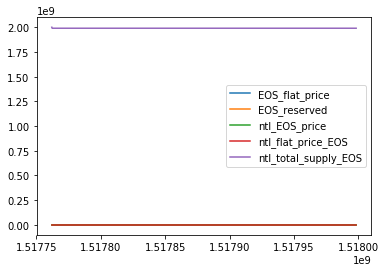

In [6]:
result[0].plot()


In [8]:
print(len(result))

2


/home/ubuntu/.virtualenvs/side-projects/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


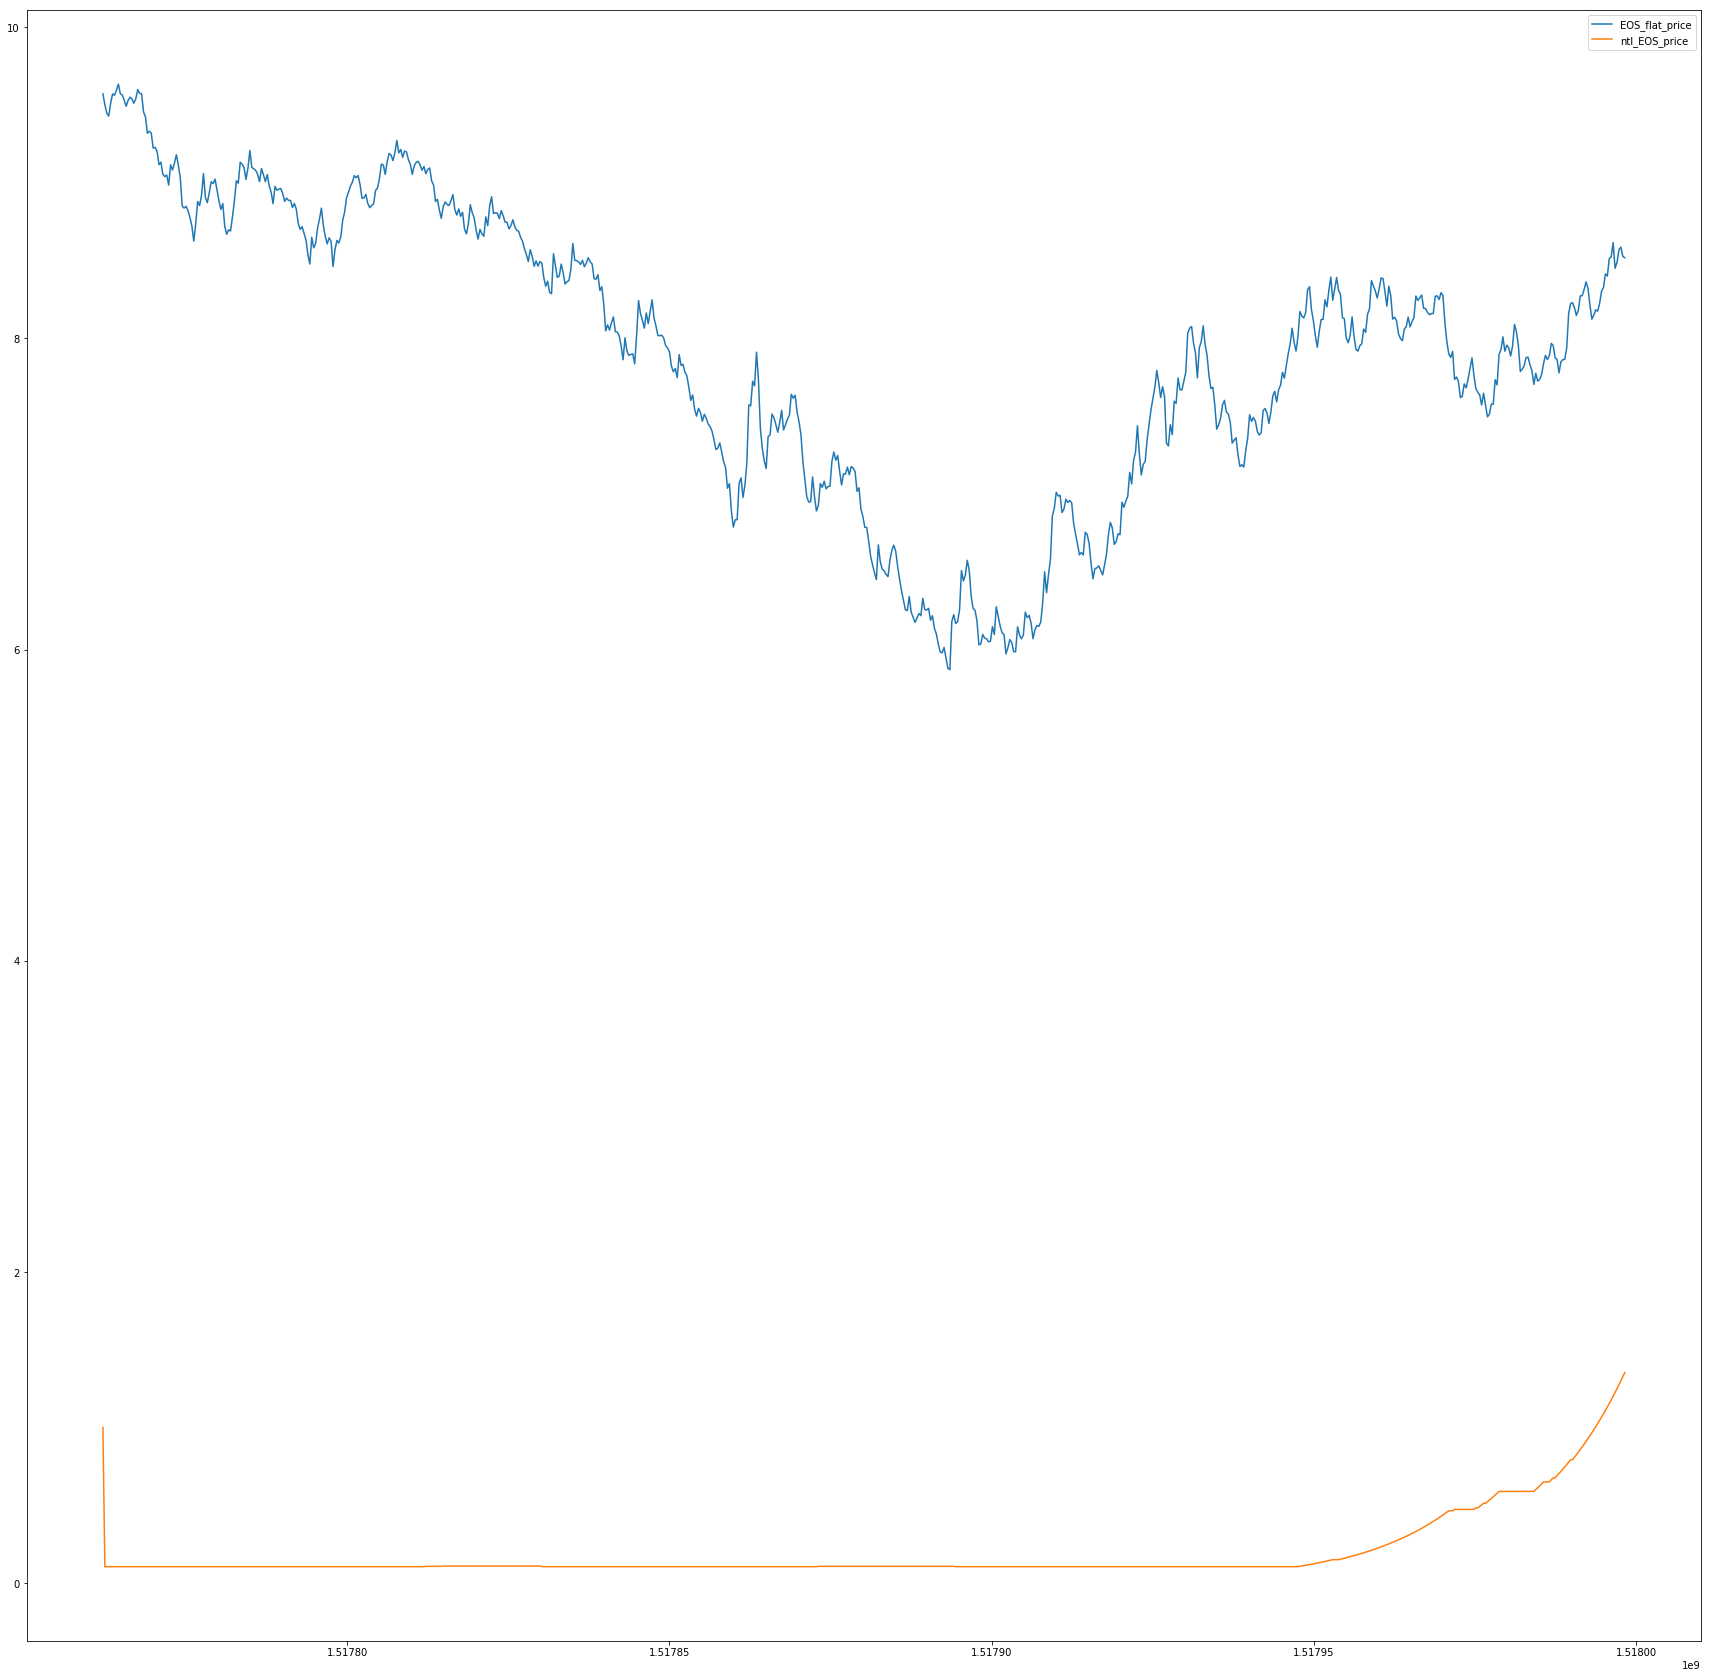

In [9]:
result[0].plot(y=['EOS_flat_price', 'ntl_EOS_price'], figsize=(30, 30))

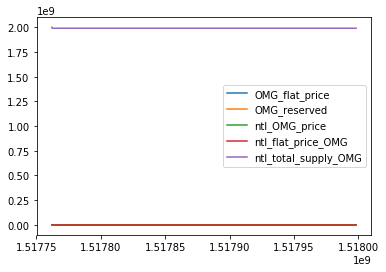

In [10]:
result[1].plot()

/home/ubuntu/.virtualenvs/side-projects/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


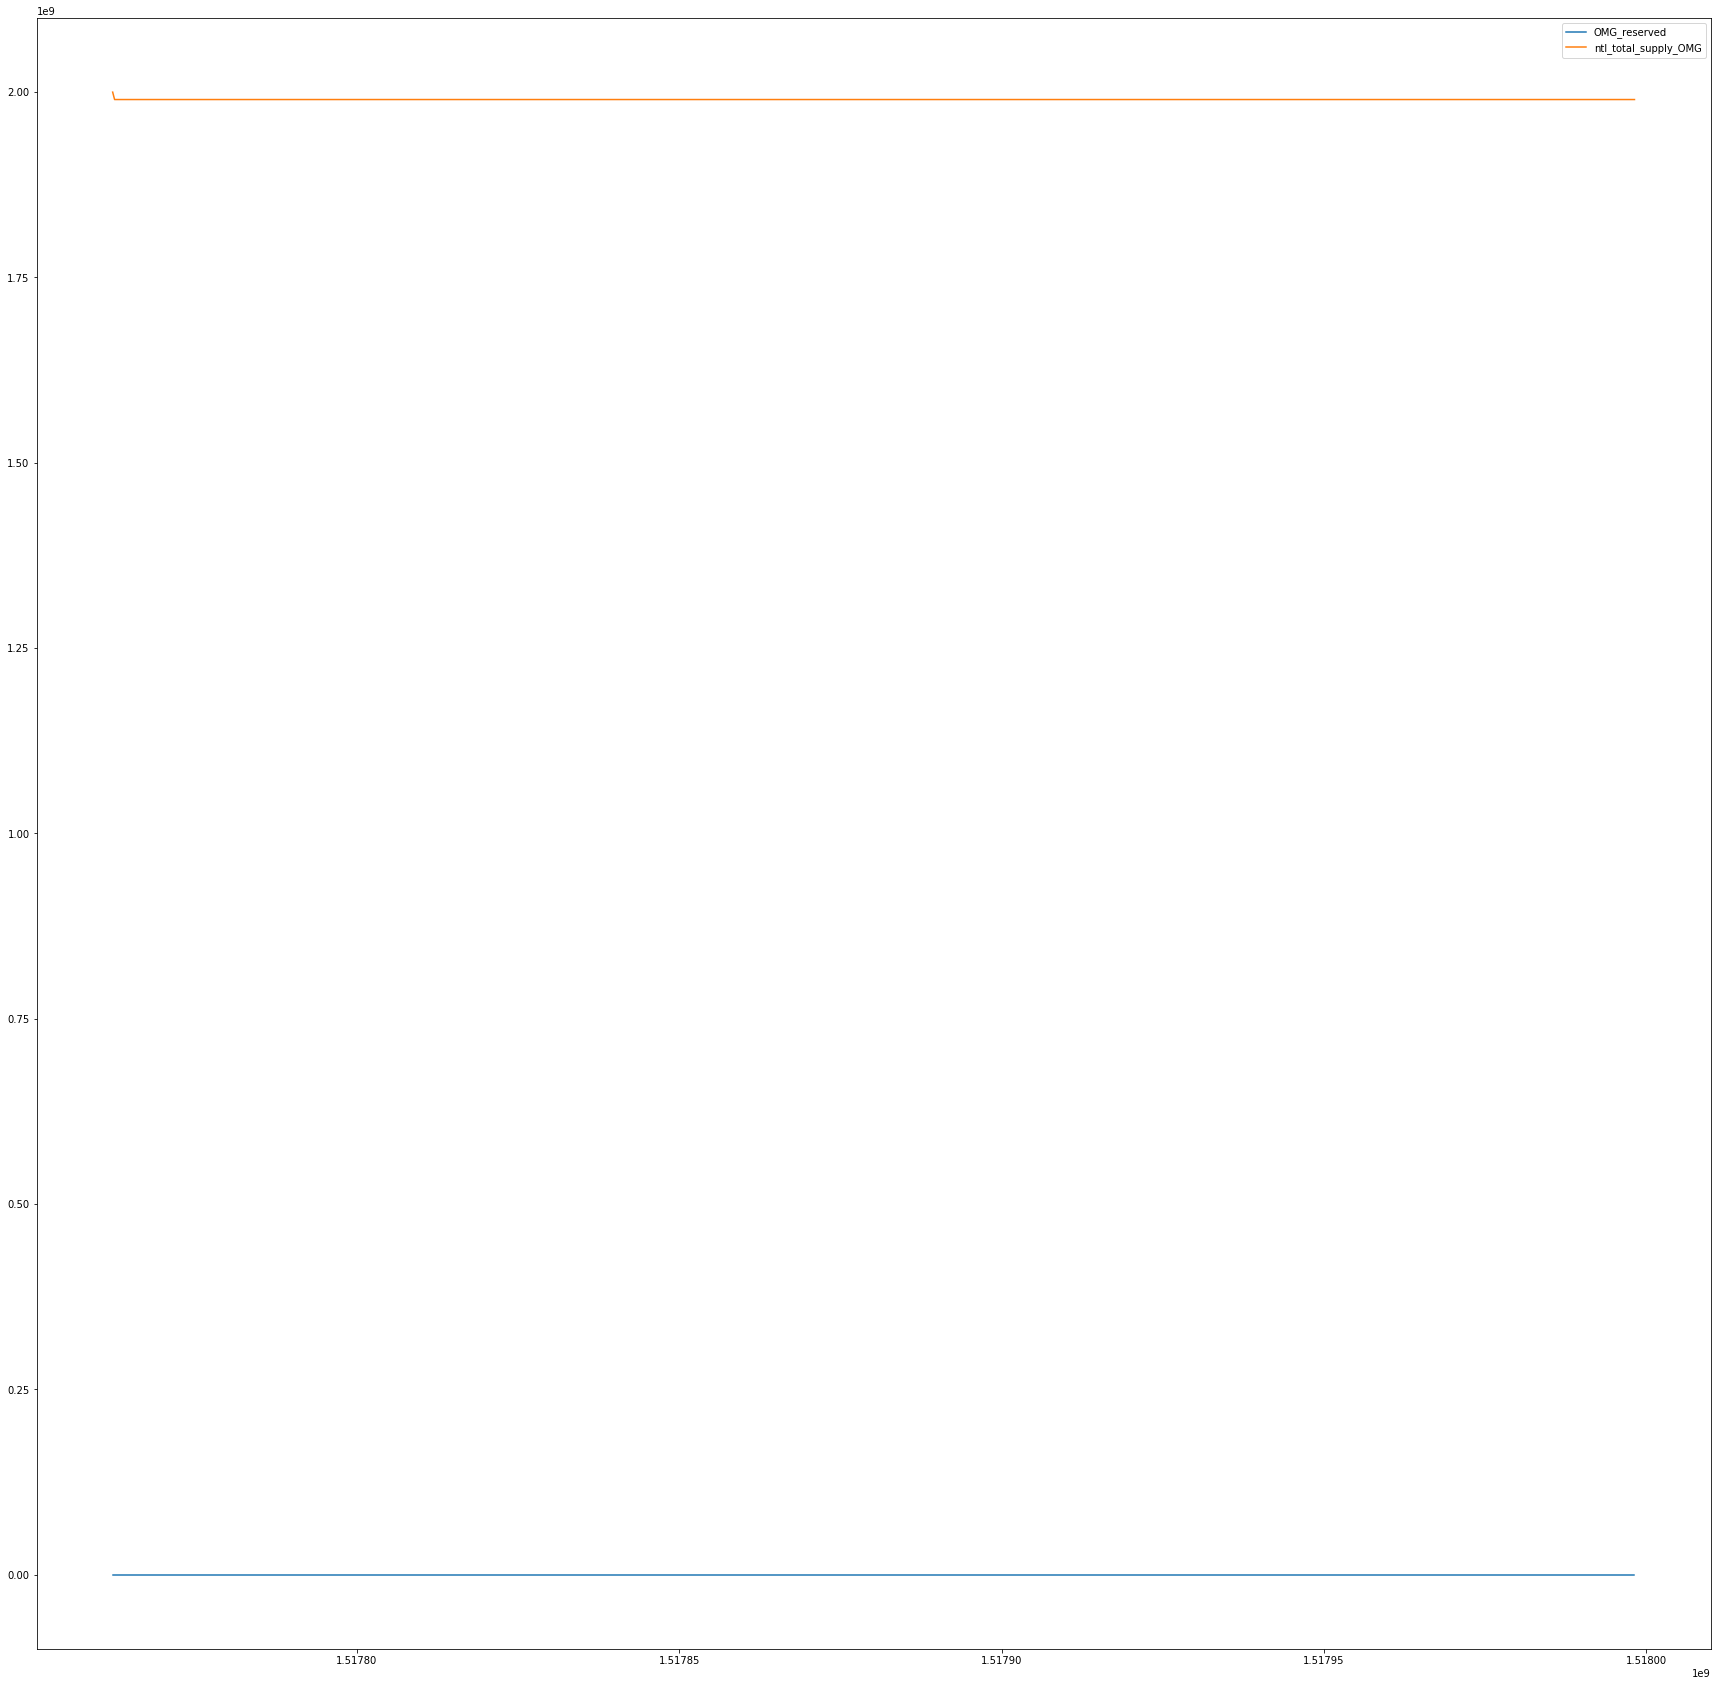

In [11]:
result[1].plot(y=['OMG_reserved', 'ntl_total_supply_OMG'], figsize=(30, 30))

/home/ubuntu/.virtualenvs/side-projects/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


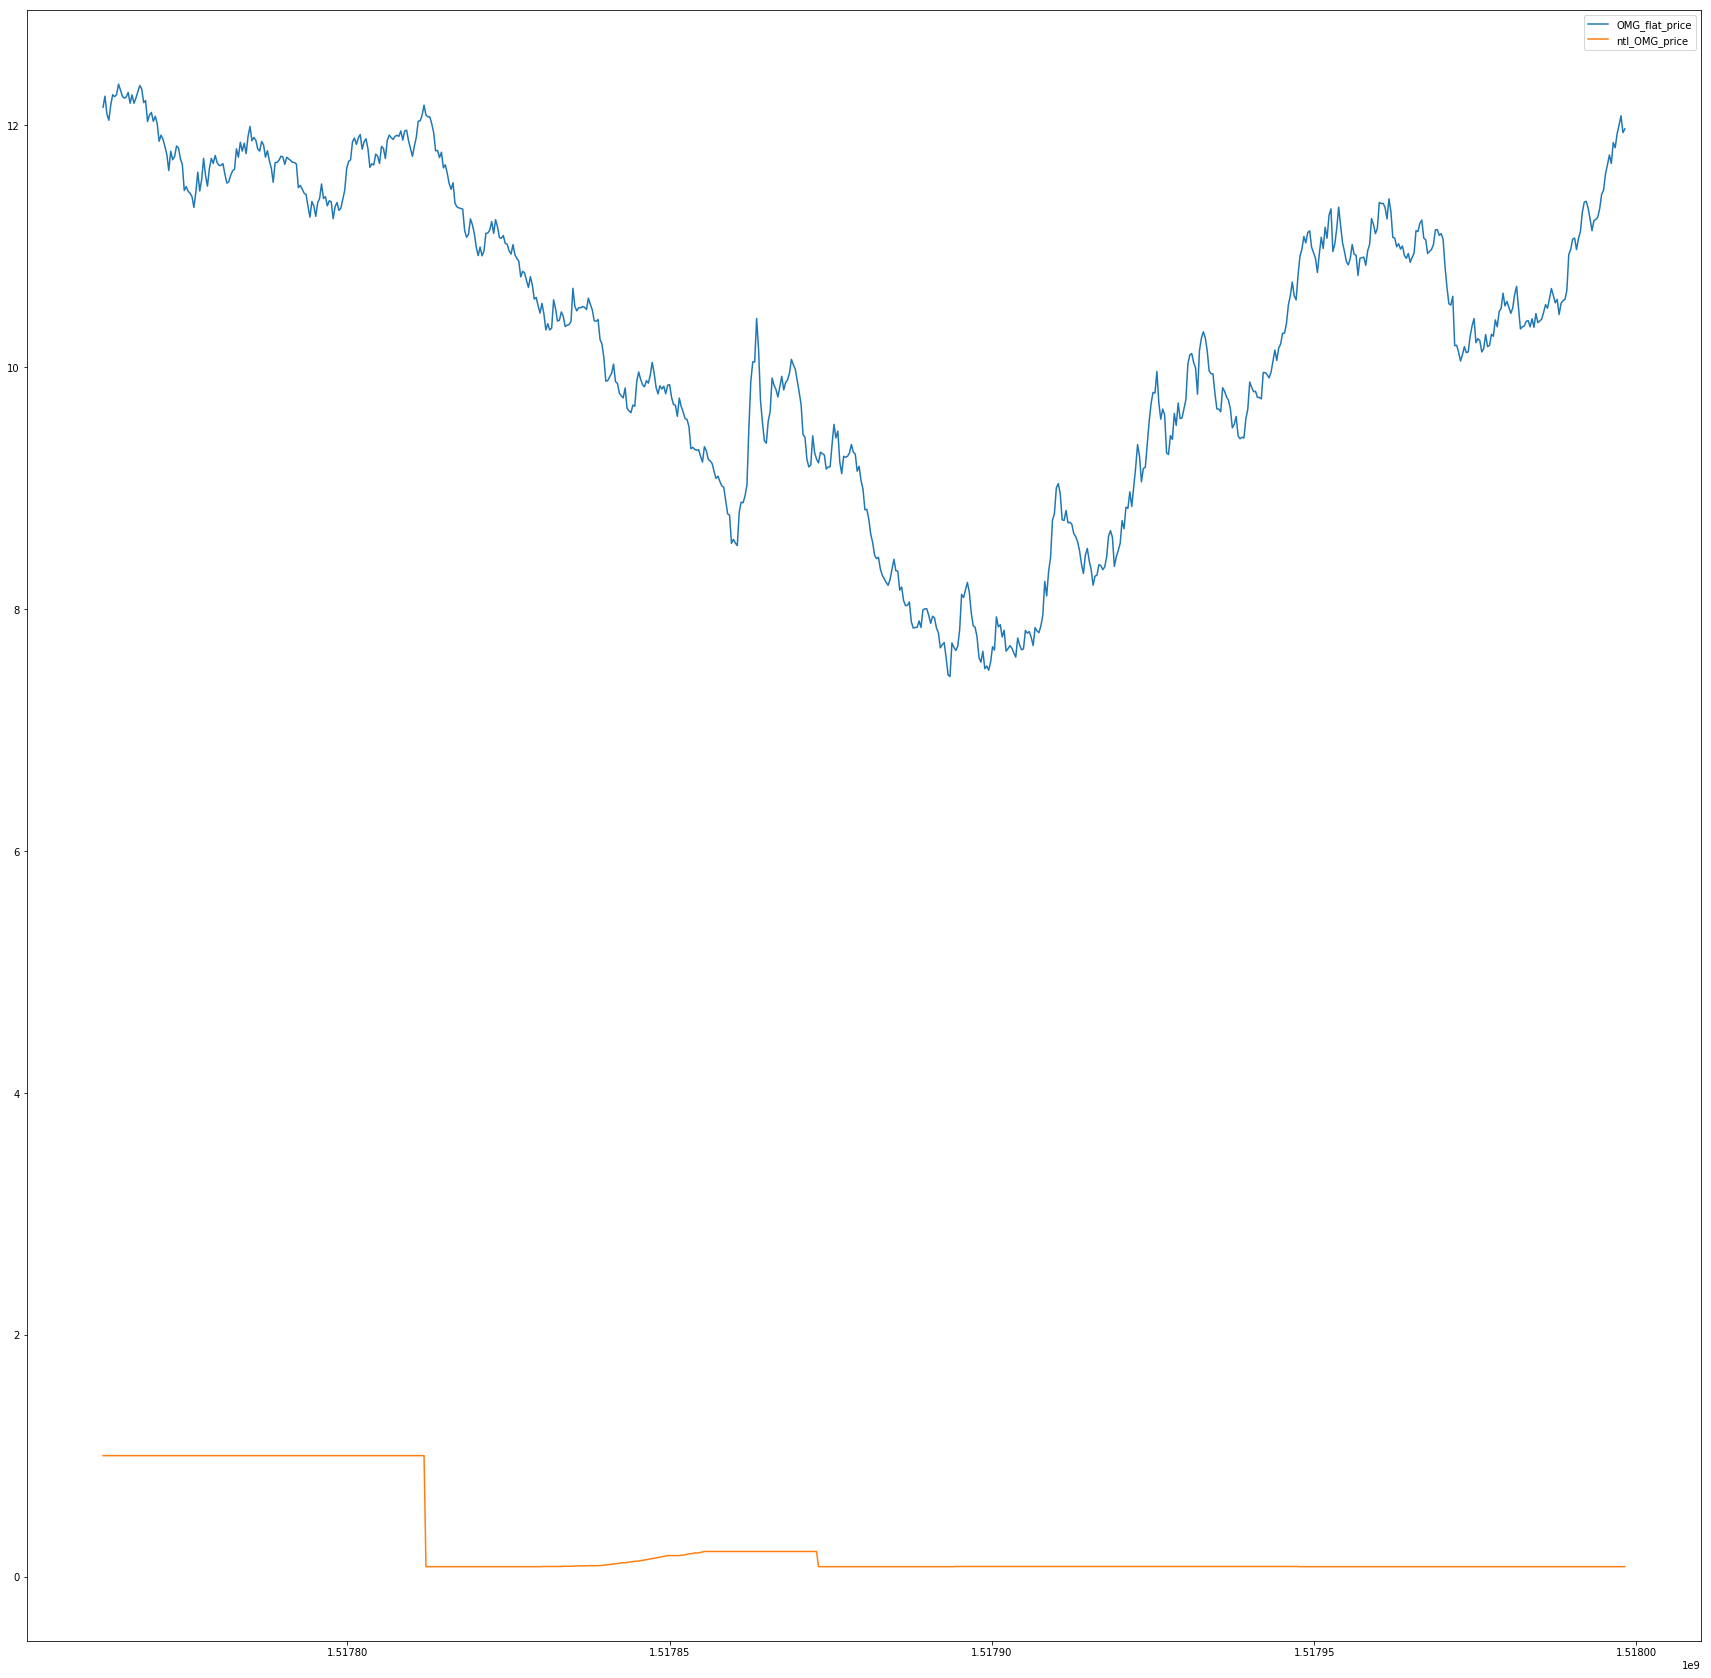

In [12]:
result[1].plot(y=['OMG_flat_price', 'ntl_OMG_price'], figsize=(30, 30))

In [16]:
concated = pd.merge(result[0], result[1], left_index=True, right_index=True)
# for index in range(2, 4):
#     concated = pd.merge(concated, result[index], left_index=True, right_index=True)


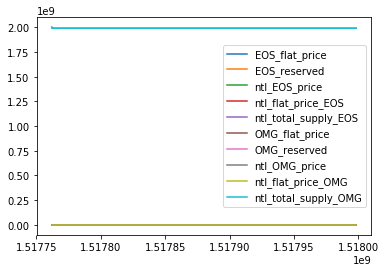

In [17]:
concated.plot()

/home/ubuntu/.virtualenvs/side-projects/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


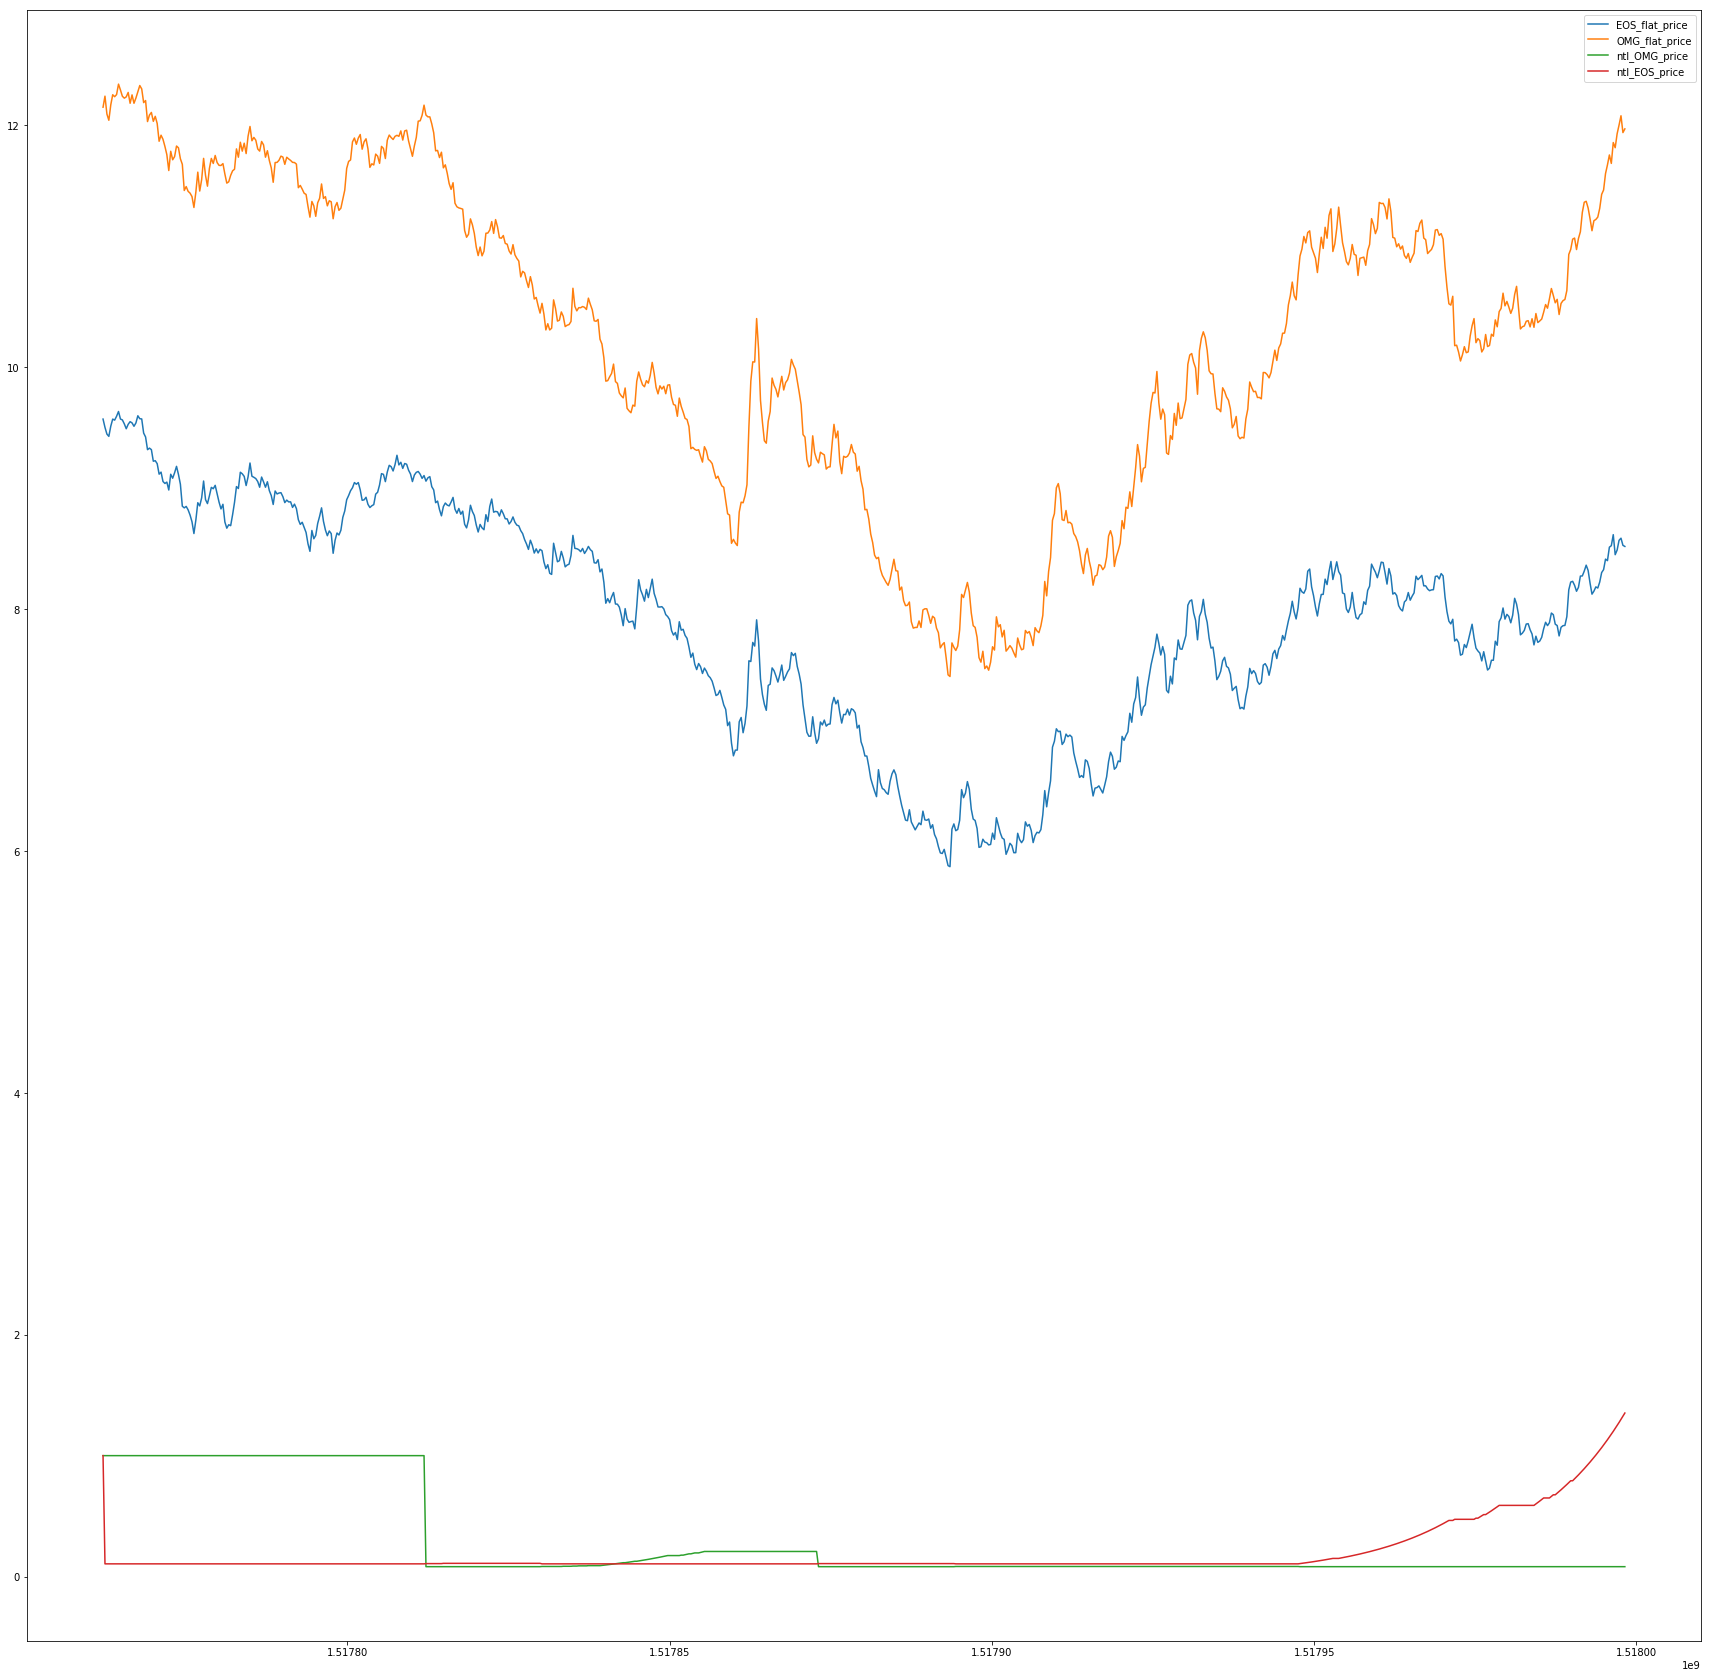

In [29]:
y = ['EOS_flat_price', 'OMG_flat_price']
y = [
    'EOS_flat_price',
    'OMG_flat_price', 
    'ntl_OMG_price', 
    'ntl_EOS_price',
#    'ntl_ELF_price', 
#    'ntl_USDT_price', 
#    'ntl_QTUM_price',
]
concated.plot(y=y, figsize=(30, 30))

In [30]:
concated['ntl_EOS_flat_price'] = concated['ntl_EOS_price'] * concated['EOS_flat_price'] 
concated['ntl_OMG_flat_price'] = concated['ntl_OMG_price'] * concated['OMG_flat_price']

/home/ubuntu/.virtualenvs/side-projects/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


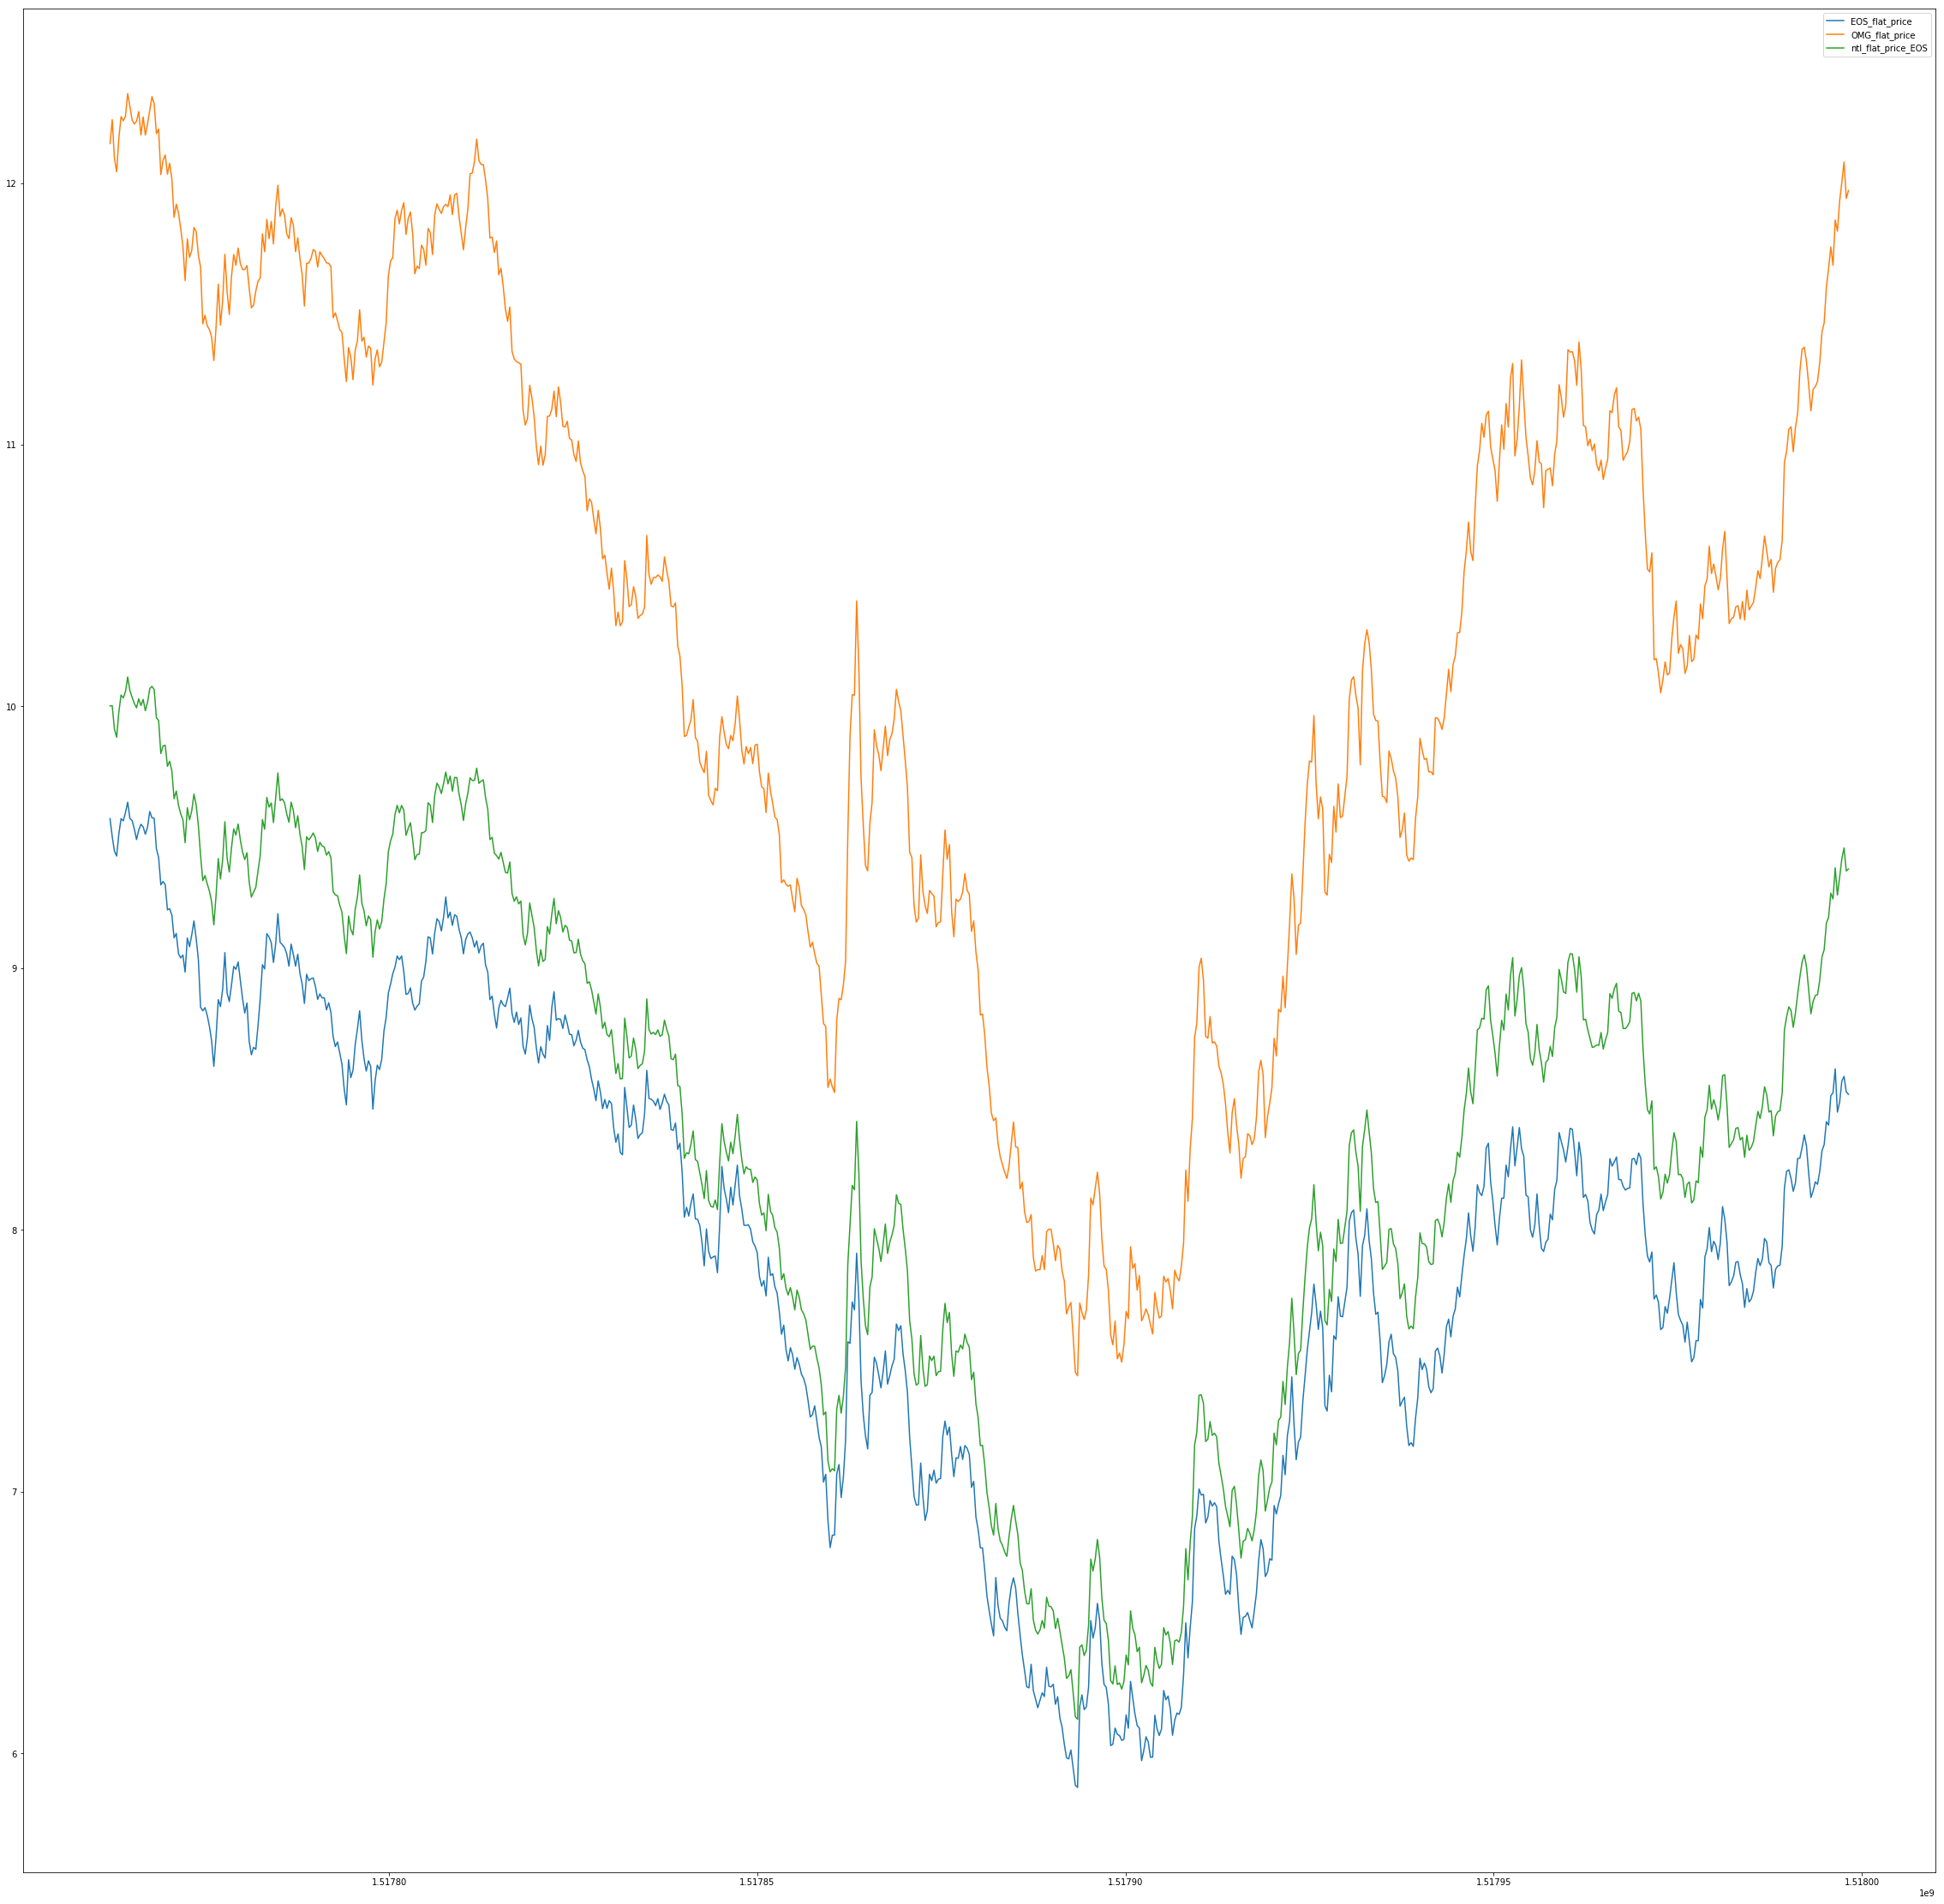

In [25]:
y = [
    'EOS_flat_price', 'OMG_flat_price', 
#    'ntl_OMG_flat_price', 'ntl_EOS_flat_price', 
    'ntl_flat_price_EOS',
]
# y = ['EOS_flat_price', 'OMG_flat_price', 'ntl_OMG_price', 'ntl_OMG_flat_price']
concated = concated[:]
concated['ntl_flat_price_EOS'] = concated['ntl_flat_price_EOS'] * 10
concated.plot(y=y, figsize=(40, 40))

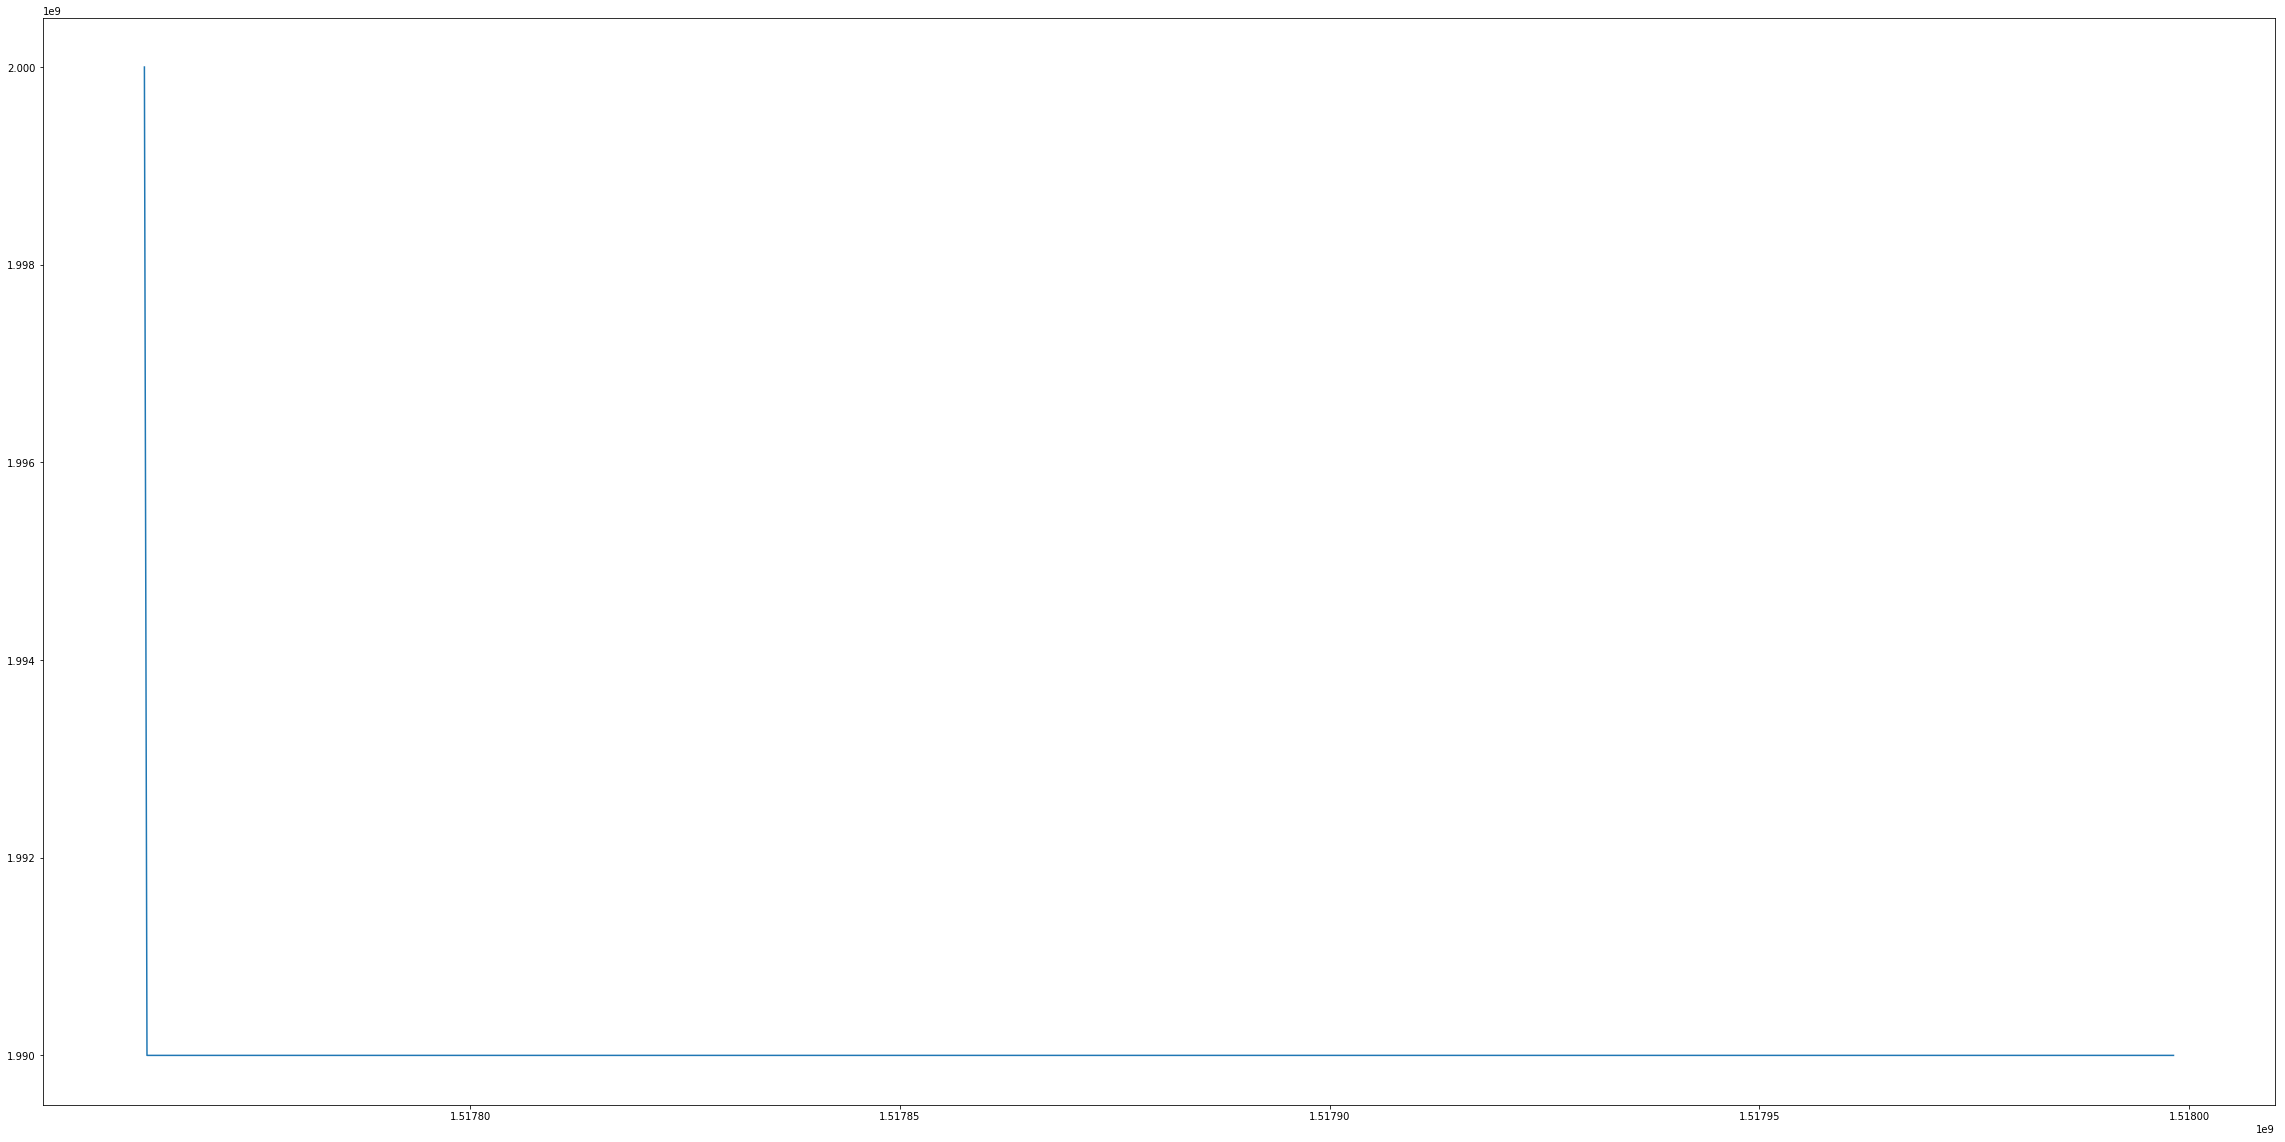

In [26]:
concated['ntl_total_supply_EOS'].plot(figsize=(40, 20))


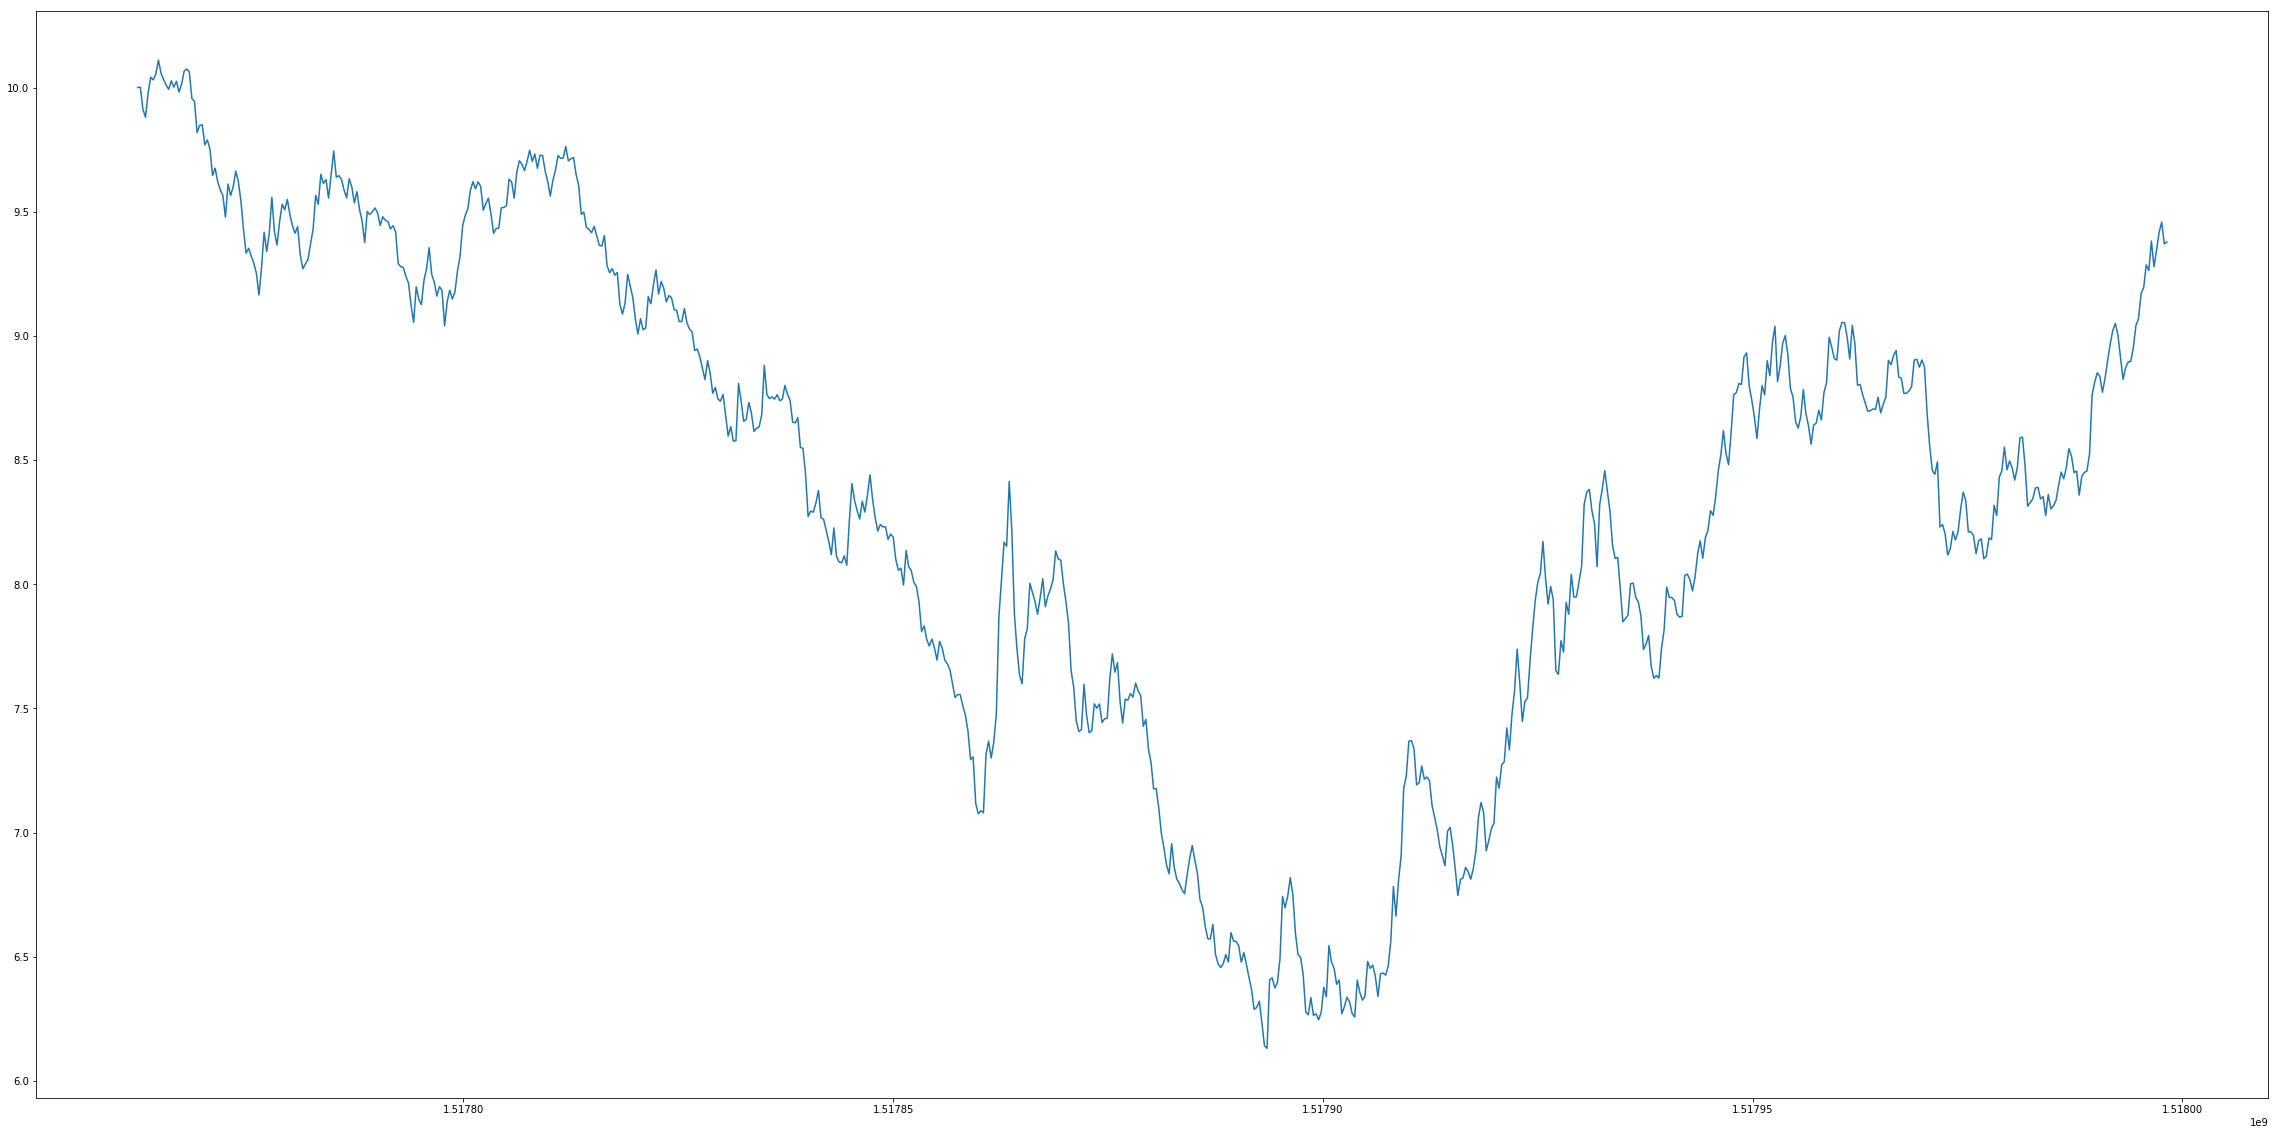

In [27]:
concated['ntl_flat_price_EOS'].plot(figsize=(40, 20))

In [28]:
instances = ['ntl_flat_price_EOS', 'OMG_flat_price', 'EOS_flat_price', 'ntl_total_supply_EOS']
for name in instances:
    print(concated[name].describe())


count    788.000000
mean       8.340004
std        1.008382
min        6.130468
25%        7.643897
50%        8.443853
75%        9.164243
max       10.112909
Name: ntl_flat_price_EOS, dtype: float64
count    788.000000
mean      10.237001
std        1.298805
min        7.443059
25%        9.320424
50%       10.383919
75%       11.324987
max       12.341486
Name: OMG_flat_price, dtype: float64
count    788.000000
mean       7.898512
std        0.921336
min        5.870379
25%        7.277662
50%        7.980185
75%        8.670074
max        9.634378
Name: EOS_flat_price, dtype: float64
count    7.880000e+02
mean     1.990013e+09
std      3.562352e+05
min      1.990000e+09
25%      1.990000e+09
50%      1.990000e+09
75%      1.990000e+09
max      2.000000e+09
Name: ntl_total_supply_EOS, dtype: float64
